# OtoWorld
Welcome to [OtoWorld](https://arxiv.org/abs/2007.06123), an interactive environment where agents must learn to listen in order to solve navigational tasks. 

To solve one episode of OtoWorld, an agent must move towards each sounding source in the auditory scene and 'turn it off'. 

The agent receives the current sound of the room (room impulse response, or RIR) as the state of the environment. The sources (created using audio files) are placed randomly within the room and can vary in number. The agent receives a reward for turning off a source.

## Topics of this Tutorial
- Environment Overview
- Environment Creation
- Agent Creation
- Oracle Agent Walkthrough

## Environment Overview
Otoworld is a game in which audio sources as placed in a room along with an agent that is tasked with finding and "turning off" each source. An agent turns off a source once it is within a specified `acceptable_radius`. The environment takes care of removing the source from the room. OtoWorld is built on three open source libraries: OpenAI Gym for environment and agent interaction, Pyroomacoustics for ray-tracing and acoustics simulation, and nussl for training deep computer audition models.

In order to better understand the workflow and enviroment configurations, we recommend reading over the descriptions of the following packages/files. 

- ```audio_room```

This is the package that holds all the source code for the gym environment. All of the various environment configurations can be found here. This includes the room configurations (size, materials, absorption rates), number of audio sources, step size, threshold radius, number of channels and more.

- ```agent.py```

This file defines the agents, including an Oracle and Random agent that inherit from the `AgentBase` class. In order to build a valid agent, only four functions must be implemented (discussed below).

- ```models.py```

Here, our main model agent (`RnnAgent`) is implemented. _`RnnAgent` can be used either as the agent or as an example to follow for users that want to create their own agents_. There is also an `RnnSeparator` class (wrapper of `nussl.ml.SeparationModel`) and a `DQN` class defining the deep Q-network architecture and the `forward()` step.

- ```constants.py```

This file contains some of the parameters used to penalize/reward an agent, build a trainable dataset and more.  

- ```datasets.py```

This file contains the source code responsible for building a dataset by capturing the state information, rewards, and actions.

- ```utils.py```

This file contains utility functions that make the OtoWorld workflow simplier. This includes functions that help randomly select audio files, visualize how well and quickly the agent is learning, and more.

- ```room_types.py```

This file implements different room shapes. OtoWorld currently supports Shoebox (rectangular) and n-shaped polygon rooms. 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import gym
import numpy as np

import sys
sys.path.append("../src")

from agent import OracleAgent
import audio_room
import constants
from datasets import BufferData
import nussl
import room_types
import utils

import warnings
warnings.filterwarnings('ignore')

nussl.utils.seed(42)

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
INFO:root:

------------------------------ 
- Starting to Fit Agent
------------------------------- 




### Environment Creation
As mentioned above, the configurable parameters for an environment can be found in audio_env.py. A few of the more important parameters are listed below:
- `room_config (List or np.array)`: dimensions of the room. 
    - For `ShoeBox`, in the form of [10,10]. For `Polygon`, in the form of `[[1,1], [1, 4], [4, 4], [4, 1]]` specifying the corners of the room.
- `step_size (float)`: step size used to move forward/backward. Defaults to 1.
- `acceptable_radius (float)`: source is considered found/turned off if agent is within this distance of source.
- `num_sources (int)`: the number of audio sources the agent will listen to in the room.
- `degrees (float)`: value of degrees to rotate in radians (use np.deg2rad to convert from degrees).
- `source_folders_dict (Dict[str, int])`: specify how many source files to choose from each folder.
                e.g.
                    {
                        'car_horn_source_folder': 1,
                        'phone_ringing_source_folder': 1
                    }
- `reset_sources`: True if you want to randomly choose new sources when resetting the environment at the end of an episode
- `same_config`: True if you want the configuration of the room to remain static over episodes (same agent initial location, same source locations, and same audio files).


#### Room Creation
Rooms are created using the Pyroomacoustics library. Users can create simple Shoebox (rectangular) room or create more complicated n-shaped polygon rooms. Through Pyroomacoustics, the environment supports the creation of rooms with different wall materials, energy absorption rates, temperatures, and humidity. You can create rooms either by importing `room_types` (our wrapper) or by directly using the Pyroomacoustics library.

In [7]:
# We want to randomly select 1 female and 1 male audio sample as sources
source_folders_dict = {"../sounds/samples/female" : 1, "../sounds/samples/male" : 1}

# Create a square 4x4 room using room_types
square_room = room_types.ShoeBox(x_length=4, y_length=4)

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    source_folders_dict=source_folders_dict,
    room_config=square_room.generate(),
    corners=square_room.corners,
    max_order=10,
    step_size=1.0,
    num_sources=2,
    acceptable_radius=1.0,
    reset_sources=False,
    same_config=True
)
env.seed(42)

Source locs [[3.4268005341393537, 0.5287089826042224], [0.9637417941561008, 2.794851862281801]]
Placing agent at [2.992663655312344, 3.229368373052742]


### Agent Creation
If you want to create your own navigational agent, you must create a subclass of the AgentBase class found in the src/agent.py. There are four functions that must be implemented.
1. ```choose_action()```
This function will decide what action you take from the action space given the current state.
2. ```update()```
This function will update the q-network.
3. ```update_stable_network()```
This function will update the stable network.
4. ```save_model()```
This function periodically will save whatever parameters you find to be valuable i.e. it saves the model

If you decide you don't need one of these functions for your agent, you can define the function and then write `pass` in the definition. 

Once these functions are implemented, call `agent.fit()` to start an experiment.

Please view the `agent.py` file to see the `RandomAgent` and `OracleAgent` classes and `RnnAgent` in `models.py` to see our main model agent implementation.

**NOTE**: Since `OracleAgent` is a perfect agent, it is necessary to make `epsilon=0` to avoid taking random actions. In order to change epsilon, we need to update the ```MAX_EPSILON``` and ```MIN_EPSILON``` constants in `constants.py` to 0.

#### Logging Information and Building a Trainable Dataset
Once we create a room to navigate, we have the option to create folders to store our buffer data, which can be quite useful for debugging. We can do this by calling the `utils.create_buffer_data_folders()` function. This function will create three folders that (1) store the dataset items, (2) new states and (3) previous states. The data will be stored in the `data/` folder.

In [8]:
# update constants.py to avoid taking random actions 
constants.MAX_EPSILON = 0
constants.MIN_EPSILON = 0

# Using utils to create folders for our data to be stored
utils.create_buffer_data_folders()
dataset = BufferData(folder=constants.DIR_DATASET_ITEMS, to_disk=False)

# create the agent with the environment config
agent = OracleAgent(
    env, 
    dataset, 
    episodes=1, 
    show_room=True, 
    play_audio=False, 
    max_steps=100
)

Let's listen to the room at the beginning of the episode

In [9]:
env.room.compute_rir()
env.room.simulate()

state = nussl.AudioSignal(
    audio_data_array=env.room.mic_array.signals,
    sample_rate=env.resample_rate
)

state.embed_audio(display=False)

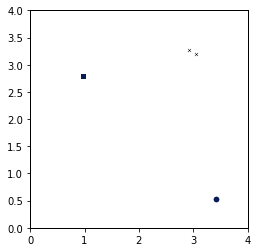

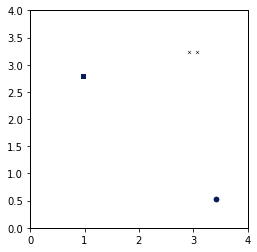

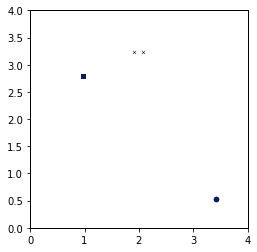

Agent has found source ../sounds/samples/male/051a050b.wav. 
Agent loc: [0.99266366 3.22936837], Source loc: [0.9637417941561008, 2.794851862281801]


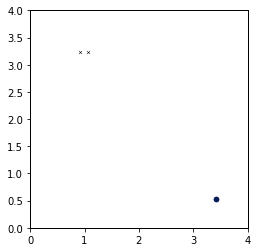

INFO:root:In FIT. Received reward 99.5 at step: 3



In FIT. Received reward: 99.5 at step 3



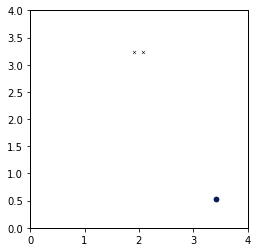

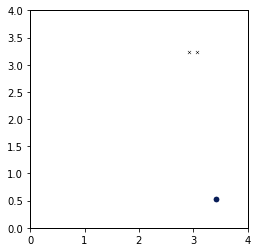

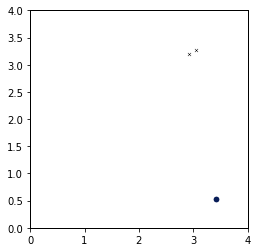

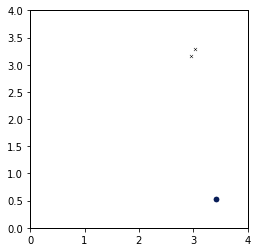

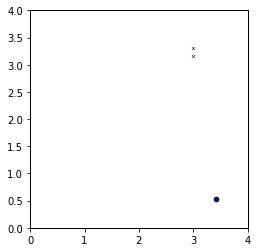

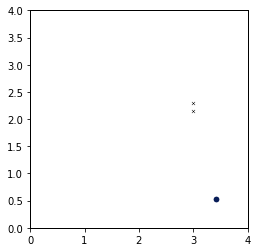

INFO:root:In FIT. Received reward 99.5 at step: 10

INFO:root:

Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 11
- Time taken:   13.430455 
- Steps/Second: 0.819034 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



Agent has found source ../sounds/samples/female/050a050c.wav. 
Agent loc: [2.992671   1.22936837], Source loc: [3.4268005341393537, 0.5287089826042224]
Source locs [[3.4268005341393537, 0.5287089826042224], [0.9637417941561008, 2.794851862281801]]
Placing agent at [2.992663655312344, 3.229368373052742]
In FIT. Received reward: 99.5 at step 10



Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 11
- Time taken:   13.430455 
- Steps/Second: 0.819034 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Source locs [[3.4268005341393537, 0.5287089826042224], [0.9637417941561008, 2.794851862281801]]
Placing agent at [2.992663655312344, 3.229368373052742]


In [10]:
# run fit!
agent.fit()

Of course, most episodes with other agents (such as `RandomAgent` or `RnnAgent`) will take much longer than this since they do not know they location of the sources. 

### The Data
If `to_disk=True` in the `BufferData` constructor, dataset items will be created that look like this: 
```
{
    "prev_state": "../data/prev_states/prev0-22.wav", 
    "action": 0, 
    "reward": 99.5, 
    “new_state": "../data/new_states/new0-22.wav"
}
```

representing the result of a step. `prev_state` and `new_state` point to the actual audio saved as .wav files. This dataset item is the result of a step forward (`action=0`) and turning off a source (100 for turning off a source - 0.5 for taking a step = 99.5).  